# Importing libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

In [4]:
binance_api_key=''
binance_api_secret=''
Binance=BinanceAPI(binance_api_key,binance_api_secret)

# Functions

In [6]:
def get_mrat(dataframe,days=30):

    #ratio=(dataframe.ewm(span=days).mean()*252)/(dataframe.ewm(span=days).std()*np.sqrt(252))
    ratio=dataframe.ewm(span=days).mean()*252
    #ratio=(dataframe.rolling(days).mean()*252)/dataframe.rolling(days).std()*np.sqrt(252)
    ratio_wo_na=ratio.dropna(how='all')

    month=list(sorted(set(ratio_wo_na.index + pd.offsets.BMonthEnd(0))))
    #month_end=pd.to_datetime(mrat_wo_na.index)
    month = pd.to_datetime(month)

    idx1 = pd.Index(ratio_wo_na.iloc[:-1].index)
    idx2 = pd.Index(month)
    closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]


    ratio_weights=ratio_wo_na.loc[closest_dates].copy().fillna(0)
    
    ratio_weights['Total']=ratio_weights.sum(axis=1)

    for col in ratio_weights.columns:
        ratio_weights[col]=ratio_weights[col]/ratio_weights['Total']

    ratio_weights=ratio_weights.drop(columns='Total')

    dates_end=list(ratio_weights.index)
    dates_end.insert(0,dataframe.index[0])
    dates_end.append(dataframe.index[-1])
    dates_end=list(set(dates_end))
    
    return ratio_weights,sorted(dates_end)

In [7]:
def get_portfolios(ratio_weights,dates_end,dataframe,weight_dict,
                   numbers_of_stocks=50,
                   investment_amount=10000,
                   transaction_fee=0.005):
    tracking={}
    portfolio={}
    initial_amount=investment_amount
    perf=dataframe.pct_change()
    
    for i in range(len(dates_end)-1):
        
        print(dates_end[i],investment_amount,investment_amount/initial_amount)

        
        temp=dataframe.loc[dates_end[i]:dates_end[i+1]].copy()
        initial_price=temp.iloc[0].to_dict()

        if dates_end[i]>dates_end[0]:

            top50=ratio_weights.loc[dates_end[i]].sort_values(ascending=False)[:numbers_of_stocks]
            top_50_rebased=top50/top50.sum()
            top_50_dict=top_50_rebased.to_dict()

            weight_dict={}

            for key in temp.columns:

                if key in top_50_dict: 
                    weight_dict[key]=top_50_dict[key]
                else:
                    weight_dict[key]=0
                    
                    
        weight_vec=np.array(list(weight_dict.values()))
        
        inital_investment_per_stock={}
        shares={}

        for col in temp.columns:
            
            weighted_perf=weight_vec*perf.loc[dates_end[i]]
            
            inital_investment_per_stock[col]=weight_dict[col]*investment_amount*(1+weighted_perf.sum())
            shares[col]=inital_investment_per_stock[col]*(1-transaction_fee)/initial_price[col]

        tracking[dates_end[i]]=(weight_dict,shares,investment_amount,initial_price)

        temp=temp*shares    
        portfolio[dates_end[i]]=temp
        investment_amount=temp.iloc[-1].sum()
        
    
    temp=dataframe.loc[dates_end[-2]:]*shares
    portfolio[dates_end[-1]]=temp
        

    return portfolio,tracking


# Importing Data

In [9]:
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()

In [10]:
days=(today-start_date).days
days

1861

In [11]:
remaining=days%500
numbers_of_table=days//500

In [12]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:80].to_list()

In [13]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(days))
data=Binance.get_price(tickers,temp_end)
prices=prices.combine_first(data)
prices=prices.sort_index()
prices = prices[~prices.index.duplicated(keep='first')]

In [14]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()

C:\Users\niroo\AppData\Local\Temp\ipykernel_169212\3293444301.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns=np.log(1+data.pct_change())


In [15]:
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)

In [16]:
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

# Strategy Backtesting

In [18]:
ratio_weights,dates_end=get_mrat(returns_to_use,days=90)

In [19]:
weight_dict={col: 1/returns_to_use.shape[1] for col in returns_to_use.columns}


In [20]:
portfolio,tracking=get_portfolios(investment_amount=100,dataframe=dataframe,numbers_of_stocks=15,weight_dict=weight_dict,
                                  ratio_weights=ratio_weights,dates_end=dates_end,
                                  transaction_fee=0)

C:\Users\niroo\AppData\Local\Temp\ipykernel_169212\2973446220.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  perf=dataframe.pct_change()


2020-01-01 00:00:00 100 1.0
2020-01-31 00:00:00 138.74071892815095 1.3874071892815096
2020-02-28 00:00:00 137.6262198452396 1.376262198452396
2020-03-31 00:00:00 90.79663536870623 0.9079663536870624
2020-04-30 00:00:00 128.21759869434402 1.2821759869434401
2020-05-29 00:00:00 157.33801217423965 1.5733801217423966
2020-06-30 00:00:00 152.18259992631008 1.5218259992631007
2020-07-31 00:00:00 259.26125563841873 2.5926125563841875
2020-08-31 00:00:00 337.41094469781194 3.374109446978119
2020-09-30 00:00:00 278.0746943025522 2.780746943025522
2020-10-30 00:00:00 239.0815634687508 2.390815634687508
2020-11-30 00:00:00 329.1009247942651 3.291009247942651
2020-12-31 00:00:00 330.00798714207156 3.3000798714207153
2021-01-29 00:00:00 661.843842909494 6.61843842909494
2021-02-26 00:00:00 1187.1181767964297 11.871181767964297
2021-03-31 00:00:00 1961.5070471079837 19.615070471079836
2021-04-30 00:00:00 3334.2657232640377 33.34265723264038
2021-05-31 00:00:00 2878.250185449859 28.78250185449859
202

In [21]:
pd.DataFrame(tracking[dates_end[-2]][0].items()).set_index(0).sort_values(by=1,ascending=False).iloc[:20]

,1
0,
DOGEUSDT,0.164468
ETCUSDT,0.148233
EOSUSDT,0.070376
ETHUSDT,0.067362
ADAUSDT,0.067253
BNBUSDT,0.066372
BCHUSDT,0.059468
VETUSDT,0.058309
NEOUSDT,0.052604


In [22]:
historical_portfolio=pd.DataFrame()
performance=pd.DataFrame()
for key in portfolio.keys():
    historical_portfolio=historical_portfolio.combine_first(portfolio[key])
    

<Axes: >

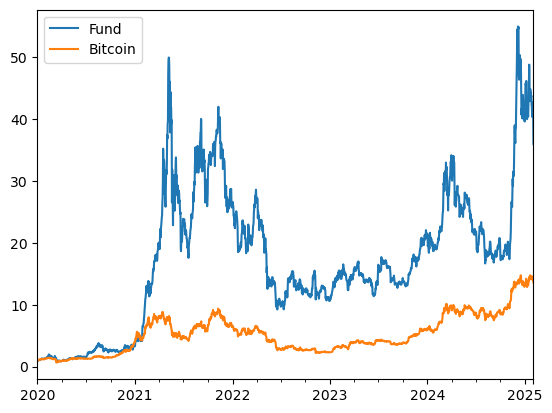

In [23]:
performance['Fund']=historical_portfolio.sum(axis=1)
performance['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_pct=performance.copy()
performance_pct=performance_pct.pct_change()

(1+performance_pct.iloc[:-2]).cumprod().plot()

In [24]:
years=sorted(list(set(performance.index.year)))

In [25]:
month_year=performance.index.strftime('%Y-%m')
month_year=sorted(list(set(month_year)))

<Axes: >

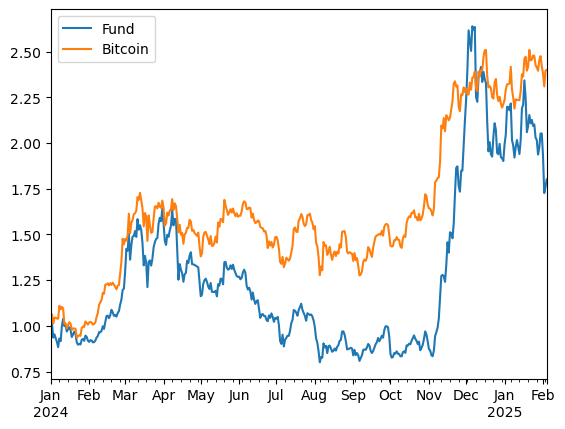

In [26]:
(1+performance_pct.loc['2024':'2025']).cumprod().plot()

In [27]:
year_returns={}
for year in years:

    perf_year=performance.loc[str(year)].iloc[-1]/performance.loc[str(year)].iloc[0]-1
    year_returns[year]=perf_year

year_returns[years[-1]]=performance.loc[str(years[-1])].iloc[-2]/performance.loc[str(years[-1])].iloc[0]-1

In [28]:
year_returns_dataframe=pd.DataFrame(year_returns)
year_returns_dataframe

,2020,2021,2022,2023,2024,2025
Fund,2.263351,6.393347,-0.595021,0.944877,0.844297,-0.117136
Bitcoin,3.016697,0.575665,-0.653364,1.544636,1.118084,0.071219


In [29]:
month_returns={}
for month in month_year:

    perf_year=performance.loc[str(month)].iloc[-1]/performance.loc[str(month)].iloc[0]-1
    month_returns[month]=perf_year

month_returns[month]=performance.loc[str(month_year[-1])].iloc[-2]/performance.loc[str(month_year[-1])].iloc[0]-1

In [30]:
month_returns_dataframe=pd.DataFrame(month_returns)
month_returns_dataframe

,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,...,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02
Fund,0.371966,-0.043178,-0.299313,0.378433,0.172194,-0.066041,0.605313,0.220143,-0.181931,-0.100998,...,0.091552,-0.177833,-0.009851,-0.117252,0.125150,0.082043,1.429344,-0.150421,0.029670,-0.088833
Bitcoin,0.298859,-0.091746,-0.248649,0.297622,0.070388,-0.104131,0.227844,-0.012851,-0.096073,0.298694,...,0.157201,-0.073706,0.027472,-0.097623,0.105158,0.156009,0.387245,-0.037137,0.082859,0.006885


In [31]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['Bitcoin']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['Bitcoin'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['Bitcoin'].iloc[-2]/performance['Bitcoin'].iloc[0]
metrics['Sharpe Ratio']=metrics['Fund Return']/metrics['Fund Vol']

In [32]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.474759
Fund Vol,0.746688
Bench Vol,0.537607
Fund Return,36.636806
Bench Return,14.071744
Sharpe Ratio,49.065766


## Totally not worth it... Better to do an Efficient Frontier